In [42]:
# ## install finrl library
# !pip install wrds
# !pip install quantstats
# !pip install torch_geometric
# !pip install swig
# !pip install -q condacolab
# import condacolab
# condacolab.install()
# !apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig
# !pip install git+https://github.com/flpymonkey/FinRL-Fork.git

In [43]:
import warnings
warnings.filterwarnings("ignore")

In [44]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.config_tickers import DOW_30_TICKER

# from finrl.agents.portfolio_optimization.architectures import EIIE

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

# import sys
# sys.path.append("../FinRL-Library")

import itertools

In [45]:
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

In [46]:
# TODO, remove DOW from training as it is missing some values in 2019
print(DOW_30_TICKER)

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [47]:
TRAIN_START_DATE = '2009-04-01'
TRAIN_END_DATE = '2020-12-31'
TEST_START_DATE = '2021-01-01'
TEST_END_DATE = '2024-01-01'

# TRAIN_START_DATE = '2010-01-01'
# TRAIN_END_DATE = '2021-10-01'
# TEST_START_DATE = '2021-10-01'
# TEST_END_DATE = '2023-03-01'
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.config_tickers import DOW_30_TICKER


# TODO Drop the DOW stock
value_to_remove = "DOW"
# Create a new list without the specified string
DOW_30_TICKER = [x for x in DOW_30_TICKER if x != value_to_remove]
print(DOW_30_TICKER)

# No time window needed for PPO
# TIME_WINDOW = 25
COMMISSION_FEE_PERCENT = 0.001
INITIAL_CASH = 1000000

# TODO try different date ranges
# TRAIN_START_DATE = '2009-01-01'
# TRAIN_END_DATE = '2018-10-01'
# TEST_START_DATE = '2018-10-01'
# TEST_END_DATE = '2021-03-01'

raw_df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = DOW_30_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS']



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%*******

Shape of DataFrame:  (107677, 8)


In [48]:
print(raw_df)

              date        open        high         low       close     volume  \
0       2009-04-01    3.717500    3.892857    3.710357    3.278073  589372000   
1       2009-04-01   48.779999   48.930000   47.099998   34.259621   10850100   
2       2009-04-01   13.340000   14.640000   13.080000   11.463930   27701800   
3       2009-04-01   34.520000   35.599998   34.209999   26.850752    9288800   
4       2009-04-01   27.500000   29.520000   27.440001   19.116177   15308300   
...            ...         ...         ...         ...         ...        ...   
107672  2023-12-29  525.979980  528.239990  523.919983  520.342346    2080100   
107673  2023-12-29  260.570007  261.459991  259.670013  258.866302    4074600   
107674  2023-12-29   37.380001   37.759998   37.320000   35.344772   16205200   
107675  2023-12-29   26.440001   26.629999   25.750000   24.868887   10853300   
107676  2023-12-29   52.509998   52.693333   52.386665   52.042637   21948300   

         tic  day  
0      

In [49]:
# INDICATORS = ['macd',
#             'rsi_30',
#             'cci_30',
#             'dx_30']

In [50]:
# from finrl.meta.preprocessor.preprocessors import FeatureEngineer
# fe = FeatureEngineer(use_technical_indicator=True,
#                      tech_indicator_list = INDICATORS,
#                      use_turbulence=True,
#                      user_defined_feature = False)

# processed = fe.preprocess_data(df)
# processed = processed.copy()
# processed = processed.fillna(0)
# processed = processed.replace(np.inf,0)

# # here you can see the engineered features are added to each stock day
# print(processed)


In [51]:
from sklearn.preprocessing import MaxAbsScaler
from finrl.meta.preprocessor.preprocessors import GroupByScaler

portfolio_norm_df = GroupByScaler(by="tic", scaler=MaxAbsScaler).fit_transform(raw_df)
portfolio_norm_df

,date,open,high,low,close,volume,tic,day
0,2009-04-01,0.018773,0.019501,0.018834,0.016610,0.313329,AAPL,0.5
1,2009-04-01,0.165873,0.164931,0.162829,0.121385,0.216841,AMGN,0.5
2,2009-04-01,0.067544,0.073365,0.066315,0.059964,0.306650,AXP,0.5
3,2009-04-01,0.077397,0.079819,0.077716,0.062400,0.089997,BA,0.5
4,2009-04-01,0.092561,0.098663,0.092690,0.065151,0.243804,CAT,0.5
...,...,...,...,...,...,...,...,...
107672,2023-12-29,0.947712,0.946497,0.952357,0.955325,0.059607,UNH,1.0
107673,2023-12-29,0.990045,0.993200,1.000000,0.992263,0.012072,V,1.0
107674,2023-12-29,0.602806,0.606879,0.608313,0.722690,0.026281,VZ,1.0
107675,2023-12-29,0.272493,0.273690,0.267421,0.363286,0.129006,WBA,1.0


In [52]:
portfolio_norm_df.groupby("tic").count()

,date,open,high,low,close,volume,day
tic,,,,,,,
AAPL,3713,3713,3713,3713,3713,3713,3713
AMGN,3713,3713,3713,3713,3713,3713,3713
AXP,3713,3713,3713,3713,3713,3713,3713
BA,3713,3713,3713,3713,3713,3713,3713
CAT,3713,3713,3713,3713,3713,3713,3713
CRM,3713,3713,3713,3713,3713,3713,3713
CSCO,3713,3713,3713,3713,3713,3713,3713
CVX,3713,3713,3713,3713,3713,3713,3713
DIS,3713,3713,3713,3713,3713,3713,3713


In [53]:
stock_dimension = len(portfolio_norm_df.tic.unique())
print(f"Stock Dimension: {stock_dimension}")

Stock Dimension: 29


In [54]:
df_train = portfolio_norm_df[(portfolio_norm_df["date"] >= TRAIN_START_DATE) & (portfolio_norm_df["date"] <= TRAIN_END_DATE)]
df_2021 = portfolio_norm_df[(portfolio_norm_df["date"] >= TEST_START_DATE) & (portfolio_norm_df["date"] <= "2021-12-31")]
df_2022 = portfolio_norm_df[(portfolio_norm_df["date"] >= "2022-01-01") & (portfolio_norm_df["date"] <= "2022-12-31")]
df_2023 = portfolio_norm_df[(portfolio_norm_df["date"] >= "2023-01-01") & (portfolio_norm_df["date"] < TEST_END_DATE)]

# TODO use the start and end date here

In [55]:
  # TODO here they use the covariance matrix for the state, look at the tutorial for:
 # FinRL_PortfolioAllocation_NeurIPS_2020

# environment = PortfolioOptimizationEnv(
#         df_train,
#         initial_amount=INITIAL_CASH,
#         comission_fee_pct=COMMISSION_FEE_PERCENT,
#         time_window=TIME_WINDOW,
#         features=["close", "high", "low"],
#         normalize_df=None
#     )

In [56]:
# import torch
# device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# # set PolicyGradient parameters
# model_kwargs = {
#     "lr": 0.01,
#     "policy": EIIE,
# }

# # here, we can set EIIE's parameters
# policy_kwargs = {
#     "k_size": 3,
#     "time_window": TIME_WINDOW,
# }

# model = DRLAgent(environment).get_model("pg", device, model_kwargs, policy_kwargs)

In [57]:

# Once optimal policy is learned it shouldnt be stochastic, giventhe state

# model = DRLAgent.train_model(model, episodes=3)

In [58]:
# torch.save(model.train_policy.state_dict(), "policy_EIIE.pt")

In [59]:
# # Test it

# environment_2021 = PortfolioOptimizationEnv(
#     df_2021,
#     initial_amount=INITIAL_CASH,
#     comission_fee_pct=COMMISSION_FEE_PERCENT,
#     time_window=TIME_WINDOW,
#     features=["close", "high", "low"],
#     normalize_df=None
# )

# environment_2022 = PortfolioOptimizationEnv(
#     df_2022,
#     initial_amount=INITIAL_CASH,
#     comission_fee_pct=COMMISSION_FEE_PERCENT,
#     time_window=TIME_WINDOW,
#     features=["close", "high", "low"],
#     normalize_df=None
# )

# environment_2023 = PortfolioOptimizationEnv(
#     df_2023,
#     initial_amount=INITIAL_CASH,
#     comission_fee_pct=COMMISSION_FEE_PERCENT,
#     time_window=TIME_WINDOW,
#     features=["close", "high", "low"],
#     normalize_df=None
# )

In [60]:
# EIIE_results = {
#     "date": environment._date_memory,
#     "training": environment._asset_memory["final"],
#     "2021": {},
#     "2022": {},
#     "2023": {}
# }

# # instantiate an architecture with the same arguments used in training
# # and load with load_state_dict.
# policy = EIIE(time_window=TIME_WINDOW, device=device)
# policy.load_state_dict(torch.load("policy_EIIE.pt"))

# # 2021
# DRLAgent.DRL_validation(model, environment_2021, policy=policy)
# EIIE_results["2021"]["value"] = environment_2021._asset_memory["final"]
# EIIE_results["2021"]["date"] = environment_2021._date_memory

# # 2022
# DRLAgent.DRL_validation(model, environment_2022, policy=policy)
# EIIE_results["2022"]["value"] = environment_2022._asset_memory["final"]
# EIIE_results["2022"]["date"] = environment_2022._date_memory

# # 2023
# DRLAgent.DRL_validation(model, environment_2023, policy=policy)
# EIIE_results["2023"]["value"] = environment_2023._asset_memory["final"]
# EIIE_results["2023"]["date"] = environment_2023._date_memory

In [61]:
# UBAH_results = {
#     "train": {},
#     "2021": {},
#     "2022": {},
#     "2023": {},
# }

# PORTFOLIO_SIZE = len(DOW_30_TICKER)

# # train period
# terminated = False
# environment.reset()
# while not terminated:
#     action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
#     _, _, terminated, _ = environment.step(action)
# UBAH_results["train"]["value"] = environment._asset_memory["final"]
# UBAH_results["train"]["date"] = environment._date_memory

# # 2021
# terminated = False
# environment_2021.reset()
# while not terminated:
#     action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
#     _, _, terminated, _ = environment_2021.step(action)
# UBAH_results["2021"]["value"] = environment_2021._asset_memory["final"]
# UBAH_results["2021"]["date"] = environment_2021._date_memory

# # 2022
# terminated = False
# environment_2022.reset()
# while not terminated:
#     action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
#     _, _, terminated, _ = environment_2022.step(action)
# UBAH_results["2022"]["value"] = environment_2022._asset_memory["final"]
# UBAH_results["2022"]["date"] = environment_2022._date_memory

# # 2023
# terminated = False
# environment_2023.reset()
# while not terminated:
#     action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
#     _, _, terminated, _ = environment_2023.step(action)
# UBAH_results["2023"]["value"] = environment_2023._asset_memory["final"]
# UBAH_results["2023"]["date"] = environment_2023._date_memory

# print(UBAH_results)

In [62]:
# import matplotlib.pyplot as plt
# %matplotlib inline 

# plt.plot(UBAH_results["train"]["date"], UBAH_results["train"]["value"], label="Buy and Hold")
# plt.plot(EIIE_results["date"], EIIE_results["training"], label="EIIE")

# plt.xlabel("Days")
# plt.ylabel("Portfolio Value")
# plt.title("Performance in training period")
# plt.legend()

# plt.show()

In [63]:
# plt.plot(UBAH_results["2021"]["date"], UBAH_results["2021"]["value"], label="Buy and Hold")
# plt.plot(EIIE_results["2021"]["date"], EIIE_results["2021"]["value"], label="EIIE")

# plt.xlabel("Days")
# plt.ylabel("Portfolio Value")
# plt.title("Performance in 2021")
# plt.legend()

# plt.show()

In [64]:
# plt.plot(UBAH_results["2022"]["date"], UBAH_results["2022"]["value"], label="Buy and Hold")
# plt.plot(EIIE_results["2022"]["date"], EIIE_results["2022"]["value"], label="EIIE")

# plt.xlabel("Days")
# plt.ylabel("Portfolio Value")
# plt.title("Performance in 2022")
# plt.legend()

# plt.show()

In [65]:
# plt.plot(UBAH_results["2023"]["date"], UBAH_results["2023"]["value"], label="Buy and Hold")
# plt.plot(EIIE_results["2023"]["date"], EIIE_results["2023"]["value"], label="EIIE")

# plt.xlabel("Days")
# plt.ylabel("Portfolio Value")
# plt.title("Performance in 2023")
# plt.legend()

# plt.show()

# TODO can I used ANOVA, or Analysis of Variance,

Compare with ANova,
Returns 
Drawdown period
And sharpe ratio

In [66]:
import torch
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [67]:
from stable_baselines3 import PPO

MODELS = {"ppo": PPO}

class DRLStableAgent:
    """Implementation for DRL algorithms for portfolio optimization.

    Note:
        During testing, the agent is optimized through online learning.
        The parameters of the policy is updated repeatedly after a constant
        period of time. To disable it, set learning rate to 0.

    Attributes:
        env: Gym environment class.
    """

    def __init__(self, env):
        """Agent initialization.

        Args:
            env: Gym environment to be used in training.
        """
        self.env = env

    def get_model(
        self, model_name, device="cpu", model_kwargs=None, policy_kwargs=None
    ):
        """Setups DRL model.

        Args:
            model_name: Name of the model according to MODELS list.
            device: Device used to instantiate neural networks.
            model_kwargs: Arguments to be passed to model class.
            policy_kwargs: Arguments to be passed to policy class.

        Note:
            model_kwargs and policy_kwargs are dictionaries. The keys must be strings
            with the same names as the class arguments. Example for model_kwargs::

            { "lr": 0.01, "policy": EIIE }

        Returns:
            An instance of the model.
        """
        if model_name not in MODELS:
            raise NotImplementedError("The model requested was not implemented.")

        model = MODELS[model_name]
        model_kwargs = {} if model_kwargs is None else model_kwargs
        policy_kwargs = {} if policy_kwargs is None else policy_kwargs

        # add device settings
        model_kwargs["device"] = device
        #policy_kwargs["device"] = device

        # add policy_kwargs inside model_kwargs
        model_kwargs["policy_kwargs"] = policy_kwargs

        # TODO default to usethe MlpPolicy
        return model(env=self.env, policy="MlpPolicy", **model_kwargs)

    @staticmethod
    def train_model(model, env, episodes=1):
        """Trains portfolio optimization model.

        Args:
            model: Instance of the model.
            episoded: Number of episodes.

        Returns:
            An instance of the trained model.
        """
        max_steps = len(env._df['date'].unique())

        print("Max number of time steps in an episode: ", max_steps)

        model.learn(
            total_timesteps = max_steps * episodes # TODO fix this
        )
        return model

    @staticmethod
    def DRL_prediction(model, env, deterministic=True):
        """make a prediction and get results"""
        test_env, test_obs = env.get_sb_env()
        
        

        test_env.reset()
        max_steps = len(env._df['date'].unique())

        validation_assets = None
        validation_dates = None

        for i in range(max_steps):
            action, _states = model.predict(test_obs, deterministic=deterministic)
            print(action)
            print(type(action))

            # Pull out the latest assets and dates
            validation_assets = env._asset_memory["final"]
            validation_dates = env._date_memory

            # account_memory = test_env.env_method(method_name="save_asset_memory")
            # actions_memory = test_env.env_method(method_name="save_action_memory")
            test_obs, rewards, dones, info = test_env.step(action)

            if dones[0]:
                print("hit end!")
                break
        
        return validation_assets, validation_dates
    

In [68]:
from finrl.meta.env_portfolio_optimization.env_portfolio_opt_stable import PortfolioOptStableEnv

# from finrl.agents.portfolio_optimization.models_stable import DRLStableAgent



from stable_baselines3.common.logger import configure
# Try also training a PPO agent on this same environment


environment = PortfolioOptStableEnv(
        df_train,
        initial_amount=INITIAL_CASH,
        comission_fee_pct=COMMISSION_FEE_PERCENT,
        # time_window=TIME_WINDOW,
        features=["close", "high", "low"],
        normalize_df=None
    )


# TODO figuring out issues with timesteps: https://stackoverflow.com/questions/56700948/understanding-the-total-timesteps-parameter-in-stable-baselines-models

agent_ppo = DRLStableAgent(env = environment)
PPO_PARAMS = {
    "n_steps": 50,
    "ent_coef": 0.01,
    "learning_rate": 0.00025, # TODO tried raising the lr which caused vanishing problem
    "clip_range": 0.2,
}

# Lower clip_range makes the stocks flatter, very conservative policy

# TODO try playing around with the number of epochs? n_epochs
# TODO try playing around more with the entropy term, make sure agent does enough exploration during training
# TODO try playing around more with the clip papram here


model_ppo = agent_ppo.get_model("ppo", device, PPO_PARAMS)

# set up logger
tmp_path = RESULTS_DIR + '/ppo'
new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
# Set new logger
model_ppo.set_logger(new_logger_ppo)

Logging to results/ppo


In [69]:
# Once optimal policy is learned it shouldnt be stochastic, giventhe state

# TODO see graphs below, need to have the correct number of timestemps and add epochs
model_ppo = DRLStableAgent.train_model(model_ppo, env=environment, episodes=1)

from finrl.config import TRAINED_MODEL_DIR

model_ppo.save(TRAINED_MODEL_DIR + "/agent_opt_ppo")

Max number of time steps in an episode:  2960
---------------------------
| time/              |    |
|    fps             | 36 |
|    iterations      | 1  |
|    time_elapsed    | 1  |
|    total_timesteps | 50 |
---------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 36         |
|    iterations           | 2          |
|    time_elapsed         | 2          |
|    total_timesteps      | 100        |
| train/                  |            |
|    approx_kl            | 0.02276538 |
|    clip_fraction        | 0.142      |
|    clip_range           | 0.2        |
|    entropy_loss         | -42.6      |
|    explained_variance   | 0.564      |
|    learning_rate        | 0.00025    |
|    loss                 | -0.516     |
|    n_updates            | 10         |
|    policy_gradient_loss | -0.0562    |
|    std                  | 1          |
|    value_loss           | 0.00131    |
--------------------

In [70]:
print(len(df_2021.index.unique()) - 1)
print(df_2021)

7307
             date      open      high       low     close    volume   tic  day
85840  2021-01-04  0.674275  0.669322  0.643452  0.641887  0.076184  AAPL  0.0
85841  2021-01-04  0.786351  0.779486  0.773249  0.714092  0.061718  AMGN  0.0
85842  2021-01-04  0.614177  0.610373  0.592425  0.586691  0.038435   AXP  0.0
85843  2021-01-04  0.470841  0.471290  0.460006  0.471113  0.205649    BA  0.0
85844  2021-01-04  0.615954  0.621591  0.608870  0.573017  0.064952   CAT  0.0
...           ...       ...       ...       ...       ...       ...   ...  ...
93143  2021-12-31  0.908360  0.908206  0.912584  0.886311  0.048583   UNH  1.0
93144  2021-12-31  0.823777  0.828034  0.829861  0.813280  0.013994     V  1.0
93145  2021-12-31  0.841800  0.840726  0.845640  0.879738  0.025804    VZ  1.0
93146  2021-12-31  0.534886  0.538746  0.538270  0.647095  0.040493   WBA  1.0
93147  2021-12-31  0.850457  0.853478  0.853203  0.829496  0.073952   WMT  1.0

[7308 rows x 8 columns]


In [71]:
PPO_results = {
    "date": environment._terminal_date_memory,
    "training": environment._terminal_asset_memory["final"],
    "2021": {},
    "2022": {},
    "2023": {}
}


environment_2021 = PortfolioOptStableEnv(
    df_2021,
    initial_amount=INITIAL_CASH,
    comission_fee_pct=COMMISSION_FEE_PERCENT,
    # time_window=TIME_WINDOW,
    features=["close", "high", "low"],
    normalize_df=None
)


environment_2022 = PortfolioOptStableEnv(
    df_2022,
    initial_amount=INITIAL_CASH,
    comission_fee_pct=COMMISSION_FEE_PERCENT,
    # time_window=TIME_WINDOW,
    features=["close", "high", "low"],
    normalize_df=None
)

environment_2023 = PortfolioOptStableEnv(
    df_2023,
    initial_amount=INITIAL_CASH,
    comission_fee_pct=COMMISSION_FEE_PERCENT,
    # time_window=TIME_WINDOW,
    features=["close", "high", "low"],
    normalize_df=None
)


print(model_ppo._num_timesteps_at_start)

# 2021
values, dates = DRLStableAgent.DRL_prediction(model_ppo, environment_2021)
PPO_results["2021"]["value"] = environment_2021._terminal_asset_memory["final"]
PPO_results["2021"]["date"] = environment_2021._terminal_date_memory


# 2022
values, dates = DRLStableAgent.DRL_prediction(model_ppo, environment_2022)
PPO_results["2022"]["value"] = environment_2022._terminal_asset_memory["final"]
PPO_results["2022"]["date"] = environment_2022._terminal_date_memory

# # 2023
# DRLStableAgent.DRL_prediction(model_ppo, environment_2023)
# PPO_results["2023"]["value"] = environment_2023._asset_memory["final"]
# PPO_results["2023"]["date"] = environment_2023._date_memory

0
[[0.         0.15752323 0.07752828 0.         0.         1.
  0.07487236 0.7870069  0.6261947  0.         0.5261562  0.07648364
  0.32655713 0.         0.4941149  0.19050708 0.6461923  0.41097906
  0.         0.         0.10667261 0.47882393 0.04401616 0.6904739
  0.         0.27959424 0.         0.17268528 0.8177757  0.        ]]
<class 'numpy.ndarray'>
[[0.         0.15752974 0.0778982  0.         0.         1.
  0.07507287 0.7880352  0.6270491  0.         0.52679    0.07677507
  0.32713842 0.         0.4947475  0.19084327 0.64695287 0.41112772
  0.         0.         0.10644201 0.479408   0.0437387  0.691118
  0.         0.28031963 0.         0.17244945 0.81886035 0.        ]]
<class 'numpy.ndarray'>
[[0.         0.15805204 0.0776953  0.         0.         1.
  0.07483569 0.791383   0.6294386  0.         0.5289917  0.0775789
  0.3287227  0.         0.49648675 0.19114874 0.64949524 0.41209444
  0.         0.         0.10689998 0.4811574  0.04381267 0.694057
  0.         0.281511   

In [72]:
print(len(df_2021['date'].unique()) - 1)

print(len(PPO_results['date']))

251
2960


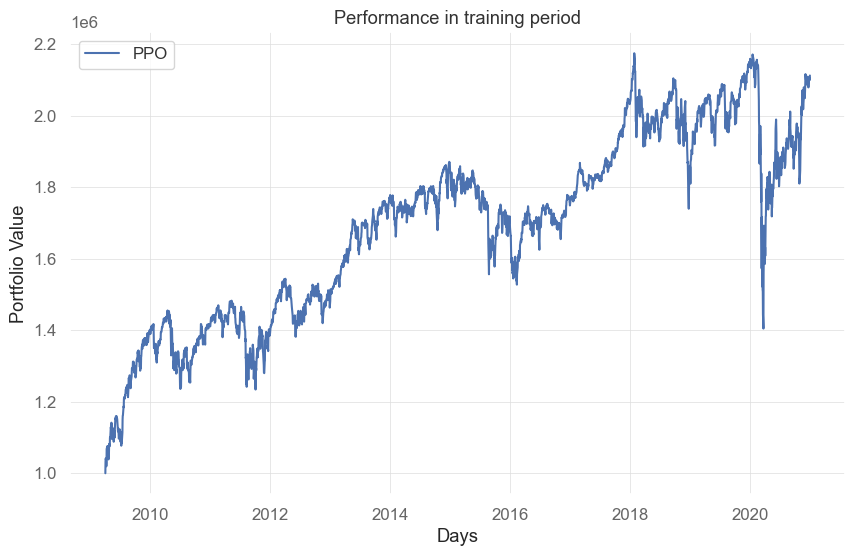

In [73]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.plot(PPO_results["date"], PPO_results["training"], label="PPO")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in training period")
plt.legend()

plt.show()

In [74]:
UBAH_results = {
    "train": {},
    "2021": {},
    "2022": {},
    "2023": {},
}

PORTFOLIO_SIZE = len(DOW_30_TICKER)



# This is the CRP strategy NOT Buy and hold 
# train period
terminated = False
environment.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment.step(action)
UBAH_results["train"]["value"] = environment._terminal_asset_memory["final"]
UBAH_results["train"]["date"] = environment._terminal_date_memory

# 2021
terminated = False
environment_2021.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_2021.step(action)
UBAH_results["2021"]["value"] = environment_2021._terminal_asset_memory["final"]
UBAH_results["2021"]["date"] = environment_2021._terminal_date_memory

# 2022
terminated = False
environment_2022.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_2022.step(action)
UBAH_results["2022"]["value"] = environment_2022._terminal_asset_memory["final"]
UBAH_results["2022"]["date"] = environment_2022._terminal_date_memory

# # 2023
# terminated = False
# environment_2023.reset()
# while not terminated:
#     action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
#     _, _, terminated, _ = environment_2023.step(action)
# UBAH_results["2023"]["value"] = environment_2023._terminal_asset_memory["final"]
# UBAH_results["2023"]["date"] = environment_2023._terminal_date_memory

KeyboardInterrupt: 

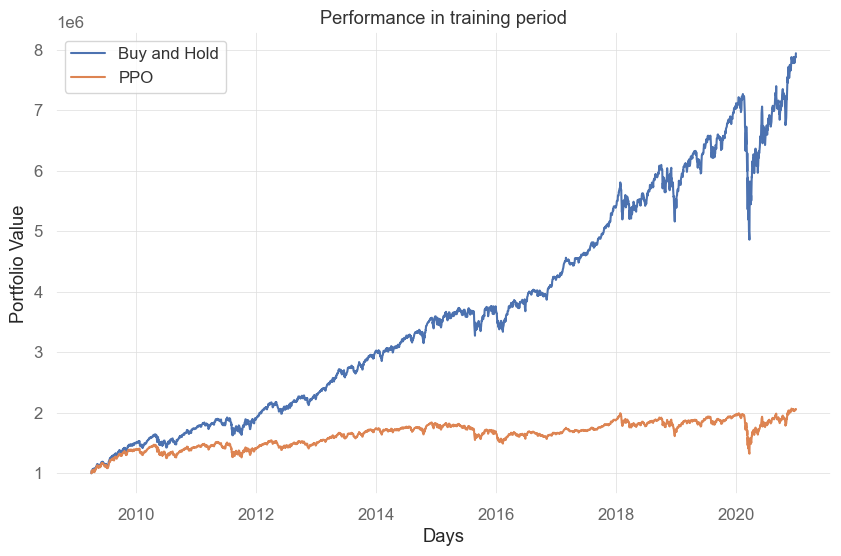

In [86]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.plot(UBAH_results["train"]["date"], UBAH_results["train"]["value"], label="Buy and Hold")
plt.plot(PPO_results["date"], PPO_results["training"], label="PPO")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in training period")
plt.legend()

plt.show()

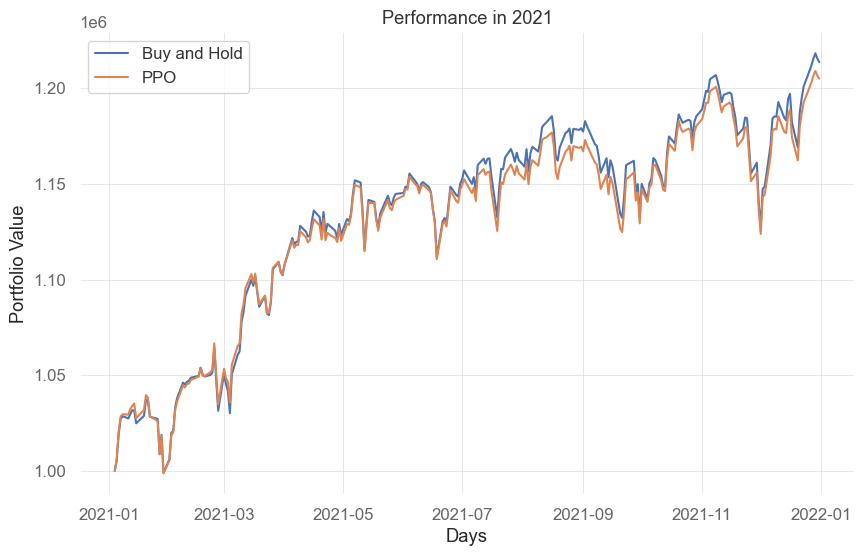

In [87]:
plt.plot(UBAH_results["2021"]["date"], UBAH_results["2021"]["value"], label="Buy and Hold")
plt.plot(PPO_results["2021"]["date"], PPO_results["2021"]["value"], label="PPO")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in 2021")
plt.legend()

plt.show()

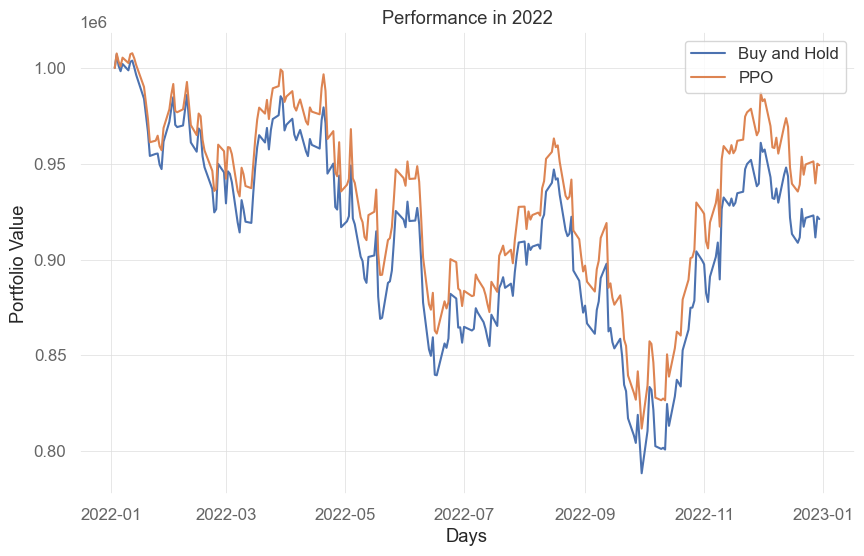

In [88]:
plt.plot(UBAH_results["2022"]["date"], UBAH_results["2022"]["value"], label="Buy and Hold")
plt.plot(PPO_results["2022"]["date"], PPO_results["2022"]["value"], label="PPO")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in 2022")
plt.legend()

plt.show()

In [89]:
# plt.plot(UBAH_results["2023"]["date"], UBAH_results["2023"]["value"], label="Buy and Hold")
# plt.plot(PPO_results["2023"]["date"], PPO_results["2023"]["value"], label="PPO")

# plt.xlabel("Days")
# plt.ylabel("Portfolio Value")
# plt.title("Performance in 2023")
# plt.legend()

# plt.show()